In [4]:
# Fix for importing utils
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.dirname(os.path.dirname(SCRIPT_DIR)))
from analysis.utils import utils

import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display
np.set_printoptions(suppress=True, formatter={'float_kind':'{:f}'.format})
font = {'family' : 'Ubuntu',
        'size'   : 22}

matplotlib.rc('font', **font)

# Visualization of Kitchen Data


Expects a folder structure of 
```
./
|- 02_Pozyx_Positioning_Data
|   |-KITCHEN
|   |-ZPOS
|
|- 03_Labels
    |-KITCHEN
    |-ZPOS
```

In [2]:
labels_dir = "03_Labels"
data_dir = "02_Pozyx_Positioning_Data"

TYPE = "KITCHEN"
ANCHORS = 4
TRIAL = 1

label_fn = f"{TYPE}_A{ANCHORS}_{TRIAL}.txt"
data_fn = f"{TYPE}_A{ANCHORS}_{TRIAL}.csv"

label_fp = Path('.').joinpath(labels_dir, TYPE, label_fn)
data_fp = Path('.').joinpath(data_dir, TYPE, data_fn)

In [3]:
# Some preprocessing
labels = utils.extract_time_labels(label_fp)

data = pd.read_csv(data_fp)
data.columns = ['Timestamp', 'POS_X', 'POS_Y', 'POS_Z', 'Heading', 'Pitch', 'Roll', 'ACC_X', 'ACC_Y', 'ACC_Z']
data = data.set_index('Timestamp')


# Sectioned Data

<AxesSubplot: title={'center': 'Kitchen Dynamic XYZ Position, Anchors=4, Red line to Black line region shows 10 sec wait at the region'}, xlabel='Timestamp', ylabel='Position (mm)'>

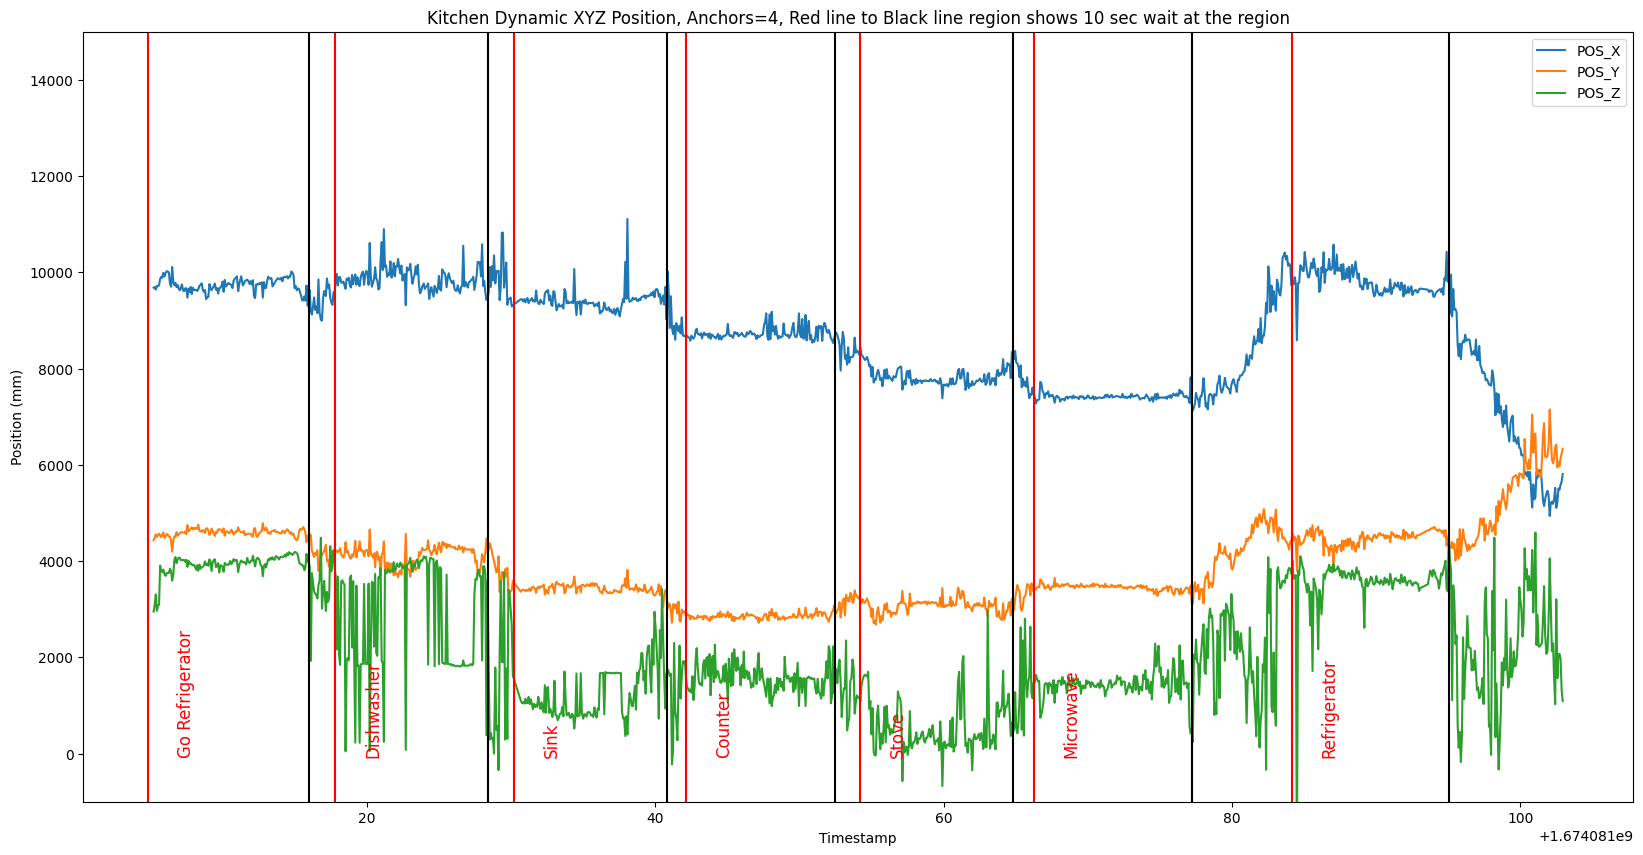

In [4]:
%matplotlib inline
#-------------------------------------------------- 
utils.plot_pozyx_data_with_timings(
    data,
    ['POS_X', 'POS_Y', 'POS_Z'],
    labels, 
    title=f"Kitchen Dynamic XYZ Position, Anchors={ANCHORS}, Red line to Black line region shows 10 sec wait at the region")

# Interactive Timeline Plot

In [9]:
GROUND_TRUTH = [
    {"label": "Fridge", "x": 9381, "y": 4664},
    {"label": "Dishwasher", "x": 9310, "y": 3944},
    {"label": "Sink", "x": 9124, "y": 3266},
    {"label": "Stove", "x": 8414, "y": 3150},
    {"label": "Microwave", "x": 7650, "y": 3330},
]

utils.plot_interactive_pozyx_data(data, f"Timeline ANCHORS={ANCHORS}", xlim=(0,12000), ylim=(0, 12000), ground_truth=GROUND_TRUTH, bg_path=Path('.').joinpath('..', 'ISL HQ Screenshot-rotated.png'), bg_multiplier=6.30)

interactive(children=(IntSlider(value=0, description='to_index', max=2000), IntSlider(value=1, description='wi…

# Further Cleaning, Time Normalization and Comparison

<AxesSubplot: title={'center': 'Data with Timings'}, ylabel='Position (mm)'>

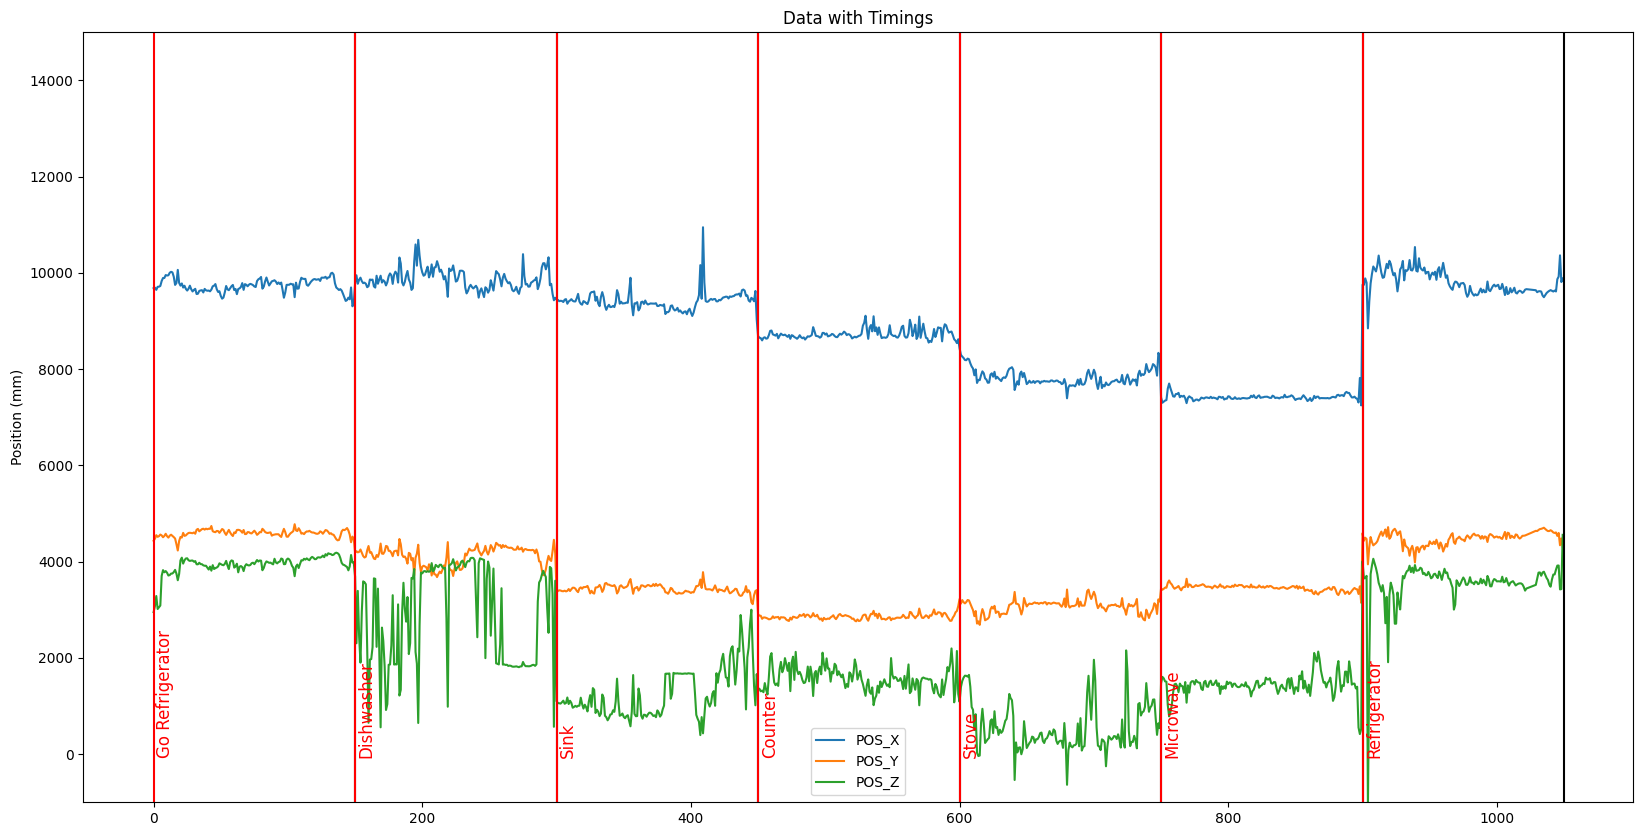

In [6]:
from scipy import interpolate

NUM_NORM_POINTS = 150

# Segment the data into only the standing still portions.
moving_periods = [[float(start['Timestamp']), float(end['Timestamp'])] for (start, end) in zip(labels[1::2], labels[2::2])]
moving_periods.append([float(labels[-1]['Timestamp']), float(labels[-1]['Timestamp'])+120])
standing_periods = [[float(start['Timestamp']), float(end['Timestamp'])] for (start, end) in zip(labels[0::2], labels[1::2])]

cleaned_data = (data
                .pipe(utils.remove_periods, moving_periods)
                .pipe(utils.interp1d_periods, standing_periods, num_points=NUM_NORM_POINTS)
                .reset_index(drop=True)
            )

# To normalize in time, drop the index and fix the indexing (make start overlap with 10sec end)
index = 0
drop_index_labels = []
for ind, _ in enumerate(labels[0::2]):
    drop_index_labels.append({'Timestamp': index, 'Label': labels[ind*2]['Label']})
    index += NUM_NORM_POINTS
    drop_index_labels.append({'Timestamp': index, 'Label': labels[ind*2+1]['Label']})


utils.plot_pozyx_data_with_timings(cleaned_data, ['POS_X', 'POS_Y', 'POS_Z'], drop_index_labels)



# Bulk Analysis

## Some thoughts

- Visually, the station can be differentiated by at least one of the POS_X or POS_Y. 
- With 4 anchors, the z still looks like a lost cause...
- Heading can be used to differentiate the sink and the counter.
- Not sure why the heading changes in the standing regions.

Text(0.5, 0, 'Index (Time normalized)')

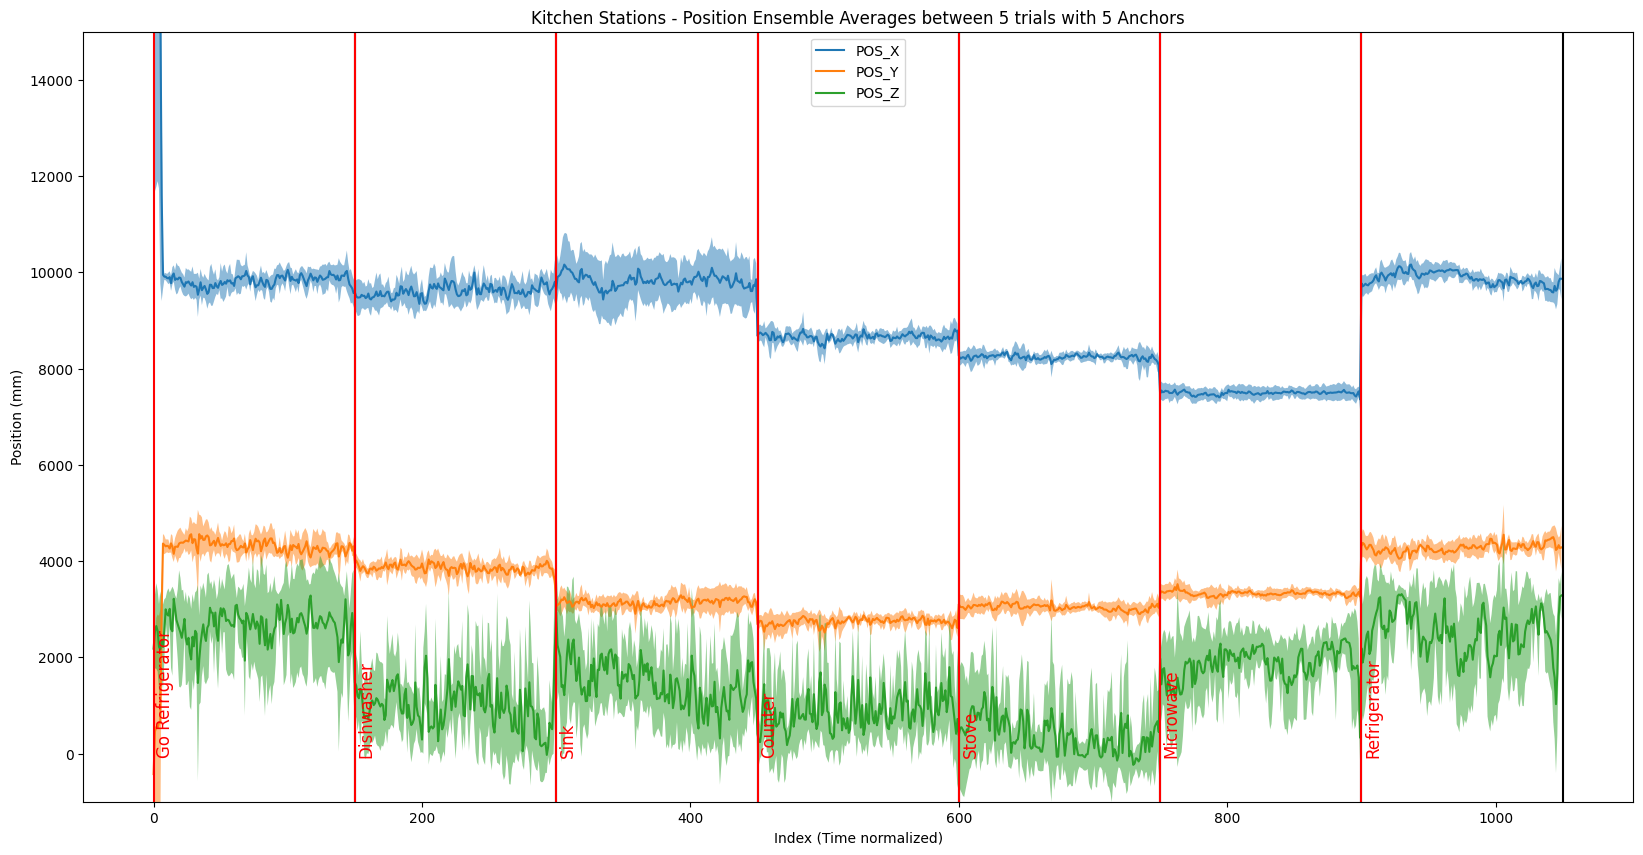

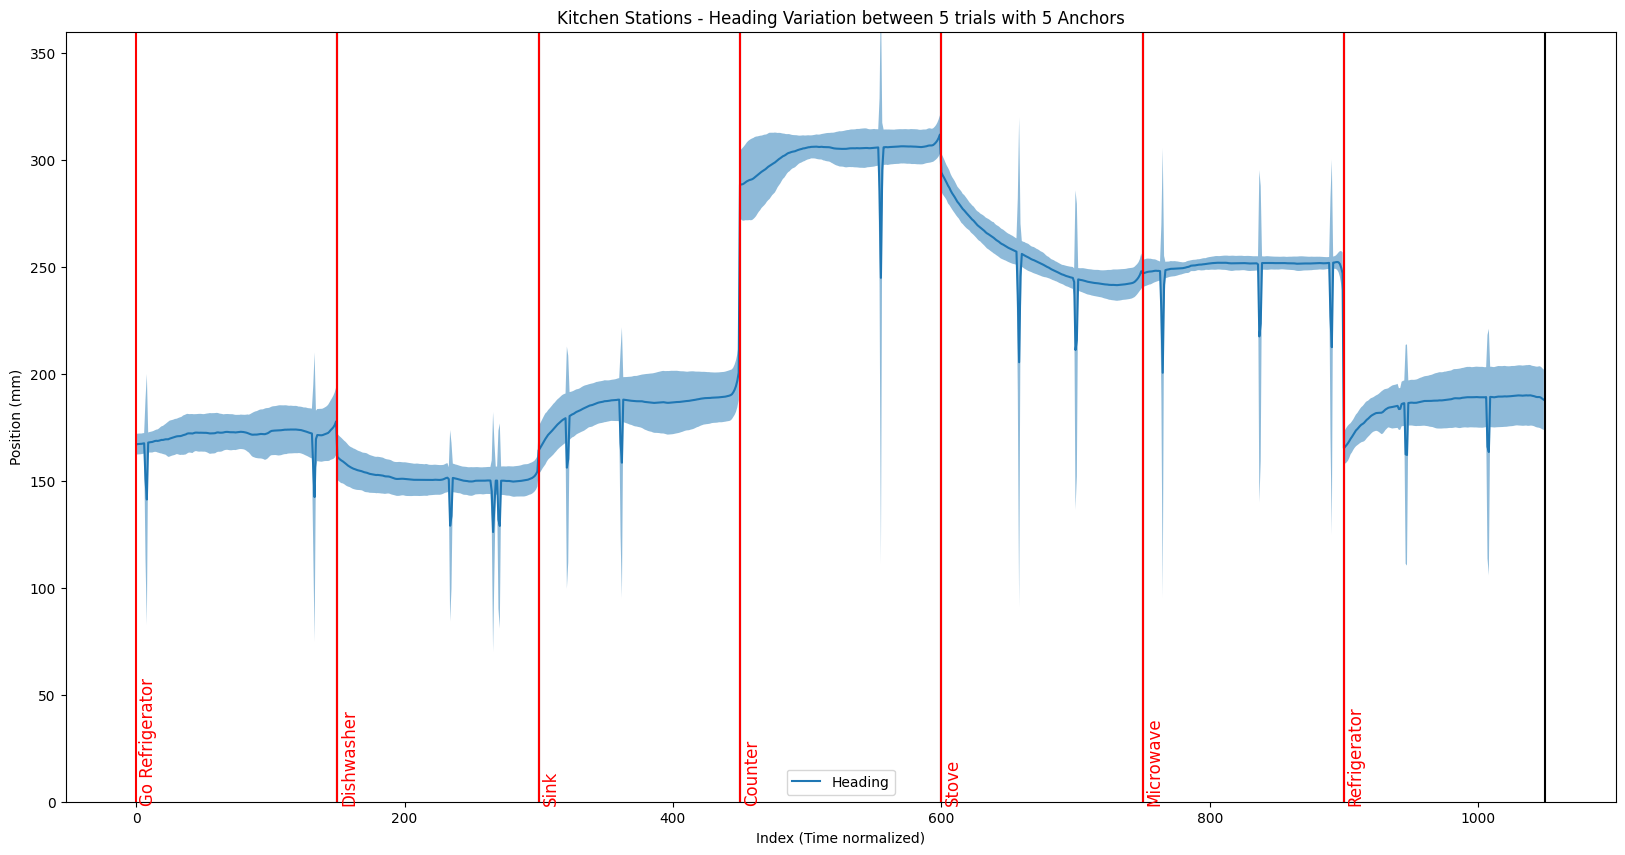

In [10]:
NUM_NORM_POINTS = 150


processed_trials = pd.DataFrame()
for trial in range(5):
    TYPE = "KITCHEN"
    ANCHORS = 4
    TRIAL = trial+1

    label_fn = f"{TYPE}_A{ANCHORS}_{TRIAL}.txt"
    data_fn = f"{TYPE}_A{ANCHORS}_{TRIAL}.csv"

    label_fp = Path('.').joinpath(labels_dir, TYPE, label_fn)
    data_fp = Path('.').joinpath(data_dir, TYPE, data_fn)

    labels = utils.extract_time_labels(label_fp)

    data = pd.read_csv(data_fp)
    data.columns = ['Timestamp', 'POS_X', 'POS_Y', 'POS_Z', 'Heading', 'Pitch', 'Roll', 'ACC_X', 'ACC_Y', 'ACC_Z']
    data = data.set_index('Timestamp')

    # Segment the data into only the standing still portions.
    moving_periods = [[float(start['Timestamp']), float(end['Timestamp'])] for (start, end) in zip(labels[1::2], labels[2::2])]
    moving_periods.append([float(labels[-1]['Timestamp']), float(labels[-1]['Timestamp'])+120])
    standing_periods = [[float(start['Timestamp']), float(end['Timestamp'])] for (start, end) in zip(labels[0::2], labels[1::2])]

    ##################### CLEANING THE DATA ########################## 
    cleaned_data = (data
                    .pipe(utils.remove_periods, moving_periods)
                    .pipe(utils.interp1d_periods, standing_periods, num_points=NUM_NORM_POINTS)
                    .reset_index(drop=True)
                )
    ##################################################################


    # To normalize in time, drop the index and fix the indexing (make start overlap with 10sec end)
    index = 0
    drop_index_labels = []
    for ind, _ in enumerate(labels[0::2]):
        drop_index_labels.append({'Timestamp': index, 'Label': labels[ind*2]['Label']})
        index += NUM_NORM_POINTS
        drop_index_labels.append({'Timestamp': index, 'Label': labels[ind*2+1]['Label']})


    # utils.plot_pozyx_data_with_timings(cleaned_data, ['POS_X', 'POS_Y', 'POS_Z'], drop_index_labels)
    # utils.plot_pozyx_data_with_timings(cleaned_data, ['Heading'], drop_index_labels, ylim=(0,360))
    processed_trials = pd.concat([processed_trials, cleaned_data], axis=0)

# Means and Standard deviations for ensemble averages
means = processed_trials.groupby(processed_trials.index).mean()
stds = processed_trials.groupby(processed_trials.index).std()

# Position
ax = utils.plot_pozyx_data_with_timings(means, ['POS_X', 'POS_Y', 'POS_Z'], drop_index_labels)
ax.fill_between(means.index, means['POS_X'] + stds['POS_X'], means['POS_X'] - stds['POS_X'], alpha=0.5)
ax.fill_between(means.index, means['POS_Y'] + stds['POS_Y'], means['POS_Y'] - stds['POS_Y'], alpha=0.5)
ax.fill_between(means.index, means['POS_Z'] + stds['POS_Z'], means['POS_Z'] - stds['POS_Z'], alpha=0.5)
ax.set_title(f"Kitchen Stations - Position Ensemble Averages between 5 trials with {ANCHORS} Anchors")
ax.set_xlabel("Index (Time normalized)")

# Heading
ax = utils.plot_pozyx_data_with_timings(means, ['Heading'], drop_index_labels, ylim=(0, 360))
ax.fill_between(means.index, means['Heading'] + stds['Heading'], means['Heading'] - stds['Heading'], alpha=0.5)
ax.set_title(f"Kitchen Stations - Heading Variation between 5 trials with {ANCHORS} Anchors")
ax.set_xlabel("Index (Time normalized)")